## Test Case III: Heat Exchanger (2D Plane)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt

src_path = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils import MIMONetDataset, DeepONetDataset, ChannelScaler
from mimonet import MIMONet

In [2]:
# check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# set working directory
working_dir = "/projects/bcnx/kazumak2/MIMONet/HeatExchanger"
data_dir = os.path.join(working_dir, "data")

## load datasets

### Load sharing parameters/dataset

In [ ]:
# trunk dataset
trunk_input = np.load(os.path.join(data_dir, "share/trunk.npz"))['trunk']

In [5]:
# for post-processing
trunk_input_orig = trunk_input.copy()

In [ ]:
# min-max scaling [-1, 1]
trunk_input[:, 0] = 2 * (trunk_input[:, 0] - np.min(trunk_input[:, 0])) / (np.max(trunk_input[:, 0]) - np.min(trunk_input[:, 0])) - 1
trunk_input[:, 1] = 2 * (trunk_input[:, 1] - np.min(trunk_input[:, 1])) / (np.max(trunk_input[:, 1]) - np.min(trunk_input[:, 1])) - 1

### Training data

In [7]:
# branch input dataset
branch = np.load(os.path.join(data_dir, "branch.npz"))

branch1 = branch['branch1']
branch2 = branch['branch2']

print("Branch1 shape:", branch1.shape)
print("Branch2 shape:", branch2.shape)

# split the dataset into training and testing sets
train_size = int(0.8 * len(branch1))
test_size = len(branch1) - train_size
train_branch1, test_branch1 = branch1[:train_size], branch1[train_size:]
train_branch2, test_branch2 = branch2[:train_size], branch2[train_size:]

Branch1 shape: (1546, 2)
Branch2 shape: (1546, 100)


In [8]:
# create a dictionary for the output channel names
# 0: turb-kinetic-energy
# 1: pressure
# 2: temperature
# 3: z-velocity
# 4: y-velocity
# 5: x-velocity
# 6: velocity-magnitude

dict_channel = {
    0: 'turb-kinetic-energy',
    1: 'pressure',
    2: 'temperature',
    3: 'z-velocity',
    4: 'y-velocity',
    5: 'x-velocity',
    6: 'velocity-magnitude'
}

# select the output channel
target_channel = [1, 3, 4, 5, 6]

# print the selected output channel names
# target_label is used to store the names of the selected output channels for further processing (e.g., plotting)
print("Selected output channels:")
target_label = []
for channel in target_channel:
    print(dict_channel[channel])
    target_label.append(dict_channel[channel])    

Selected output channels:
pressure
z-velocity
y-velocity
x-velocity
velocity-magnitude


In [9]:
# target dataset
target = np.load(os.path.join(data_dir, "target.npy"))

# extract the output channels
target = target[:, :, target_channel ]  # select the first 7 channels
print("Target dataset shape before split:", target.shape)


# split the target dataset into training and testing sets
train_target = target[:train_size]
test_target = target[train_size:]

print("Train target shape:", train_target.shape)
print("Test target shape:", test_target.shape)

Target dataset shape before split: (1546, 3977, 5)
Train target shape: (1236, 3977, 5)
Test target shape: (310, 3977, 5)


In [10]:
# (# train samples, 2) 
# get the mean and standard deviation of each channel
mean_branch1 = np.mean(train_branch1, axis=0)
std_branch1 = np.std(train_branch1, axis=0)

print("Mean of branch1:", mean_branch1)
print("Std of branch1:", std_branch1)

# (# train samples, 100)
mean_branch2 = np.mean(train_branch2)
std_branch2 = np.std(train_branch2)

print("Mean of branch2:", mean_branch2)
print("Std of branch2:", std_branch2)

Mean of branch1: [  4.51454429 292.42944177]
Std of branch1: [ 0.2615285  17.03323994]
Mean of branch2: 12587.66968713018
Std of branch2: 6302.709013835411


In [11]:
# normalize the branch data using the mean and std
train_branch_1 = (train_branch1 - mean_branch1) / std_branch1
test_branch_1 = (test_branch1 - mean_branch1) / std_branch1
train_branch_2 = (train_branch2 - mean_branch2) / std_branch2
test_branch_2 = (test_branch2 - mean_branch2) / std_branch2

# print the shapes of the normalized data
print("Shape of normalized train_branch1:", train_branch_1.shape)
print("Shape of normalized test_branch1:", test_branch_1.shape)
print("Shape of normalized train_branch2:", train_branch_2.shape)
print("Shape of normalized test_branch2:", test_branch_2.shape)

Shape of normalized train_branch1: (1236, 2)
Shape of normalized test_branch1: (310, 2)
Shape of normalized train_branch2: (1236, 100)
Shape of normalized test_branch2: (310, 100)


### Scaling the target data

In [12]:
# scaling the target data
'''  
note: reverse the scaling for the target data
train_target = scaler.inverse_transform(train_target_scaled)
test_target = scaler.inverse_transform(test_target_scaled)
'''
scaler = ChannelScaler(method='minmax', feature_range=(-1, 1))
scaler.fit(train_target)
train_target_scaled = scaler.transform(train_target)
test_target_scaled = scaler.transform(test_target)

print("Shape of scaled train_target:", train_target_scaled.shape)
print("Shape of scaled test_target:", test_target_scaled.shape)

Shape of scaled train_target: (1236, 3977, 5)
Shape of scaled test_target: (310, 3977, 5)


## Torch Dataset and DataLoader

In [13]:
# test dataset and dataloader
test_dataset = MIMONetDataset(
    [test_branch_1, test_branch_2],  # branch_data_list
    trunk_input,                     # trunk_data
    test_target_scaled               # target_data
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # set to 1 for testing
    shuffle=False,
    num_workers=0
)

In [ ]:
train_dataset = MIMONetDataset(
    [train_branch_1, train_branch_2],  # branch_data_list
    trunk_input,                       # trunk_data
    train_target_scaled                # target_data
)

## MIMONet Model

In [ ]:
# Architecture parameters
dim = 256
branch_input_dim1 = 2
branch_input_dim2 = 100
trunk_input_dim = 2

# Define the model arguments for orig_MIMONet
model_args = {
    'branch_arch_list': [
        [branch_input_dim1, 512, 512, 512, dim],
        [branch_input_dim2, 512, 512, 512, dim]
    ],
    'trunk_arch': [trunk_input_dim, 256, 256, 256, dim],
    'num_outputs': target.shape[-1] -1,  # number of output channels
    'activation_fn': nn.ReLU,
    'merge_type': 'mul',
}

In [16]:
from training import train_model

In [17]:
# scheduler parameters
scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_args={'mode': 'min', 'factor': 0.5, 'patience': 10,}

In [ ]:
def velocity_magnitude_loss(pred, target):
    # pred: (B, N, 3) → u, v, w
    # target: (B, N, 4) → u, v, w, |u|

    pred_u = pred[..., 1]
    pred_v = pred[..., 2]
    pred_w = pred[..., 3]

    pred_mag = torch.sqrt(pred_u**2 + pred_v**2 + pred_w**2 + 1e-8)  # avoid sqrt(0)
    true_mag = target[..., 4]

    return torch.mean((pred_mag - true_mag)**2)

class MSEWithVelocityMagnitudeLoss(nn.Module):
    def __init__(self, lambda_mag=0.1):
        super().__init__()
        self.lambda_mag = lambda_mag
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        # pred: [B, N, 5] → [p, w, v, u, |u|]
        # target: [B, N, 5] → same order

        loss_data = self.mse(pred[..., :4], target[..., :4])  # match p, w, v, u
        loss_mag = velocity_magnitude_loss(pred, target)

        return loss_data + self.lambda_mag * loss_mag


In [19]:
criterion = MSEWithVelocityMagnitudeLoss(lambda_mag=0.0001)

In [20]:
def run():
    train_model(
        model_fn=MIMONet,
        model_args=model_args,
        optimizer_fn=torch.optim.Adam,
        optimizer_args={'lr': 1e-3, 'weight_decay': 1e-6},
        scheduler_fn=scheduler_fn,
        scheduler_args=scheduler_args,
        dataset=train_dataset,
        device=device,
        num_epochs=500,
        batch_size=4,
        #criterion=nn.MSELoss(),
        criterion=criterion,
        patience=500,
        k_fold=None,
        multi_gpu=False,
        working_dir="/projects/bcnx/kazumak2/MIMONet/HeatExchanger/",
    )

# start the training
#run()

### Evaluation with Test Dataset

In [21]:
model = MIMONet(**model_args).to(device)
# Load the trained model
model_path = os.path.join(working_dir, "checkpoints/custom_best_model_lambda_1E-4.pt")

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully from", model_path)
else:
    print("Model file not found at", model_path)
    sys.exit(1)
    
# Evaluate the model on the test set
model.eval()

# print the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters in the model: {num_params}")

Model loaded successfully from /projects/bcnx/kazumak2/MIMONet/HeatExchanger/checkpoints/custom_best_model_lambda_1E-4.pt
Number of trainable parameters in the model: 1762052


In [22]:
# feed the test loader to the model (and save predictions and targets)
predictions = []
targets = []
with torch.no_grad():
    for batch in test_loader:
        branch_data, trunk_data, target_data = batch
        branch_data = [b.to(device) for b in branch_data]
        trunk_data = trunk_data.to(device)
        target_data = target_data.to(device)

        output = model(branch_data, trunk_data)
        predictions.append(output.cpu().numpy())
        targets.append(target_data.cpu().numpy())
# Convert predictions and targets to numpy arrays
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# Reverse the scaling for the target data
predictions = scaler.inverse_transform(predictions)
targets = scaler.inverse_transform(targets)

# save the predictions and targets to .npz file
output_file = os.path.join(working_dir, "results/predictions_and_targets.npz")
np.savez(output_file, predictions=predictions, targets=targets)

In [23]:
# Compute L2 norm over grid points for each sample and channel
l2_pred = np.linalg.norm(predictions, axis=1)  # shape: (samples, channels)
l2_gt = np.linalg.norm(targets[..., :4], axis=1)  # shape: (samples, channels)

print("L2 norm of predictions shape:", l2_pred.shape)
print("L2 norm of targets shape:", l2_gt.shape)


# Compute L2 error over grid points for each sample and channel
l2_err = np.linalg.norm(predictions - targets[..., :4], axis=1)  # shape: (samples, channels)

# Compute relative error (avoid division by zero)
rel_err = l2_err / (l2_gt + 1e-8)  # shape: (samples, channels)

# Mean over samples for each channel
mean_rel_err_per_channel = np.mean(rel_err, axis=0)  # shape: (channels,)

print("Mean relative L2 error per channel:", mean_rel_err_per_channel * 100, "%")

# standard deviation of relative error per channel
std_rel_err_per_channel = np.std(rel_err, axis=0)  # shape: (channels,)

print("Standard deviation of relative L2 error per channel:", std_rel_err_per_channel)

L2 norm of predictions shape: (310, 4)
L2 norm of targets shape: (310, 4)
Mean relative L2 error per channel: [0.79963773 1.4521601  1.015162   0.5177918 ] %
Standard deviation of relative L2 error per channel: [0.00014584 0.0002911  0.0002742  0.00038389]


In [24]:
# compute the mean of the l2 error per sample
mean_l2_err_per_sample = np.mean(rel_err, axis=1)  # shape: (samples,)

# get the idxs of the samples with the highest mean L2 error and the lowest mean L2 error
highest_err_idx = np.argmax(mean_l2_err_per_sample)
lowest_err_idx = np.argmin(mean_l2_err_per_sample)
print("Sample with highest mean L2 error index:", highest_err_idx)
print("Sample with lowest mean L2 error index:", lowest_err_idx)

print("Highest mean L2 error sample:", mean_l2_err_per_sample[highest_err_idx])
print("Lowest mean L2 error sample:", mean_l2_err_per_sample[lowest_err_idx])

Sample with highest mean L2 error index: 261
Sample with lowest mean L2 error index: 177
Highest mean L2 error sample: 0.010436695
Lowest mean L2 error sample: 0.009172571


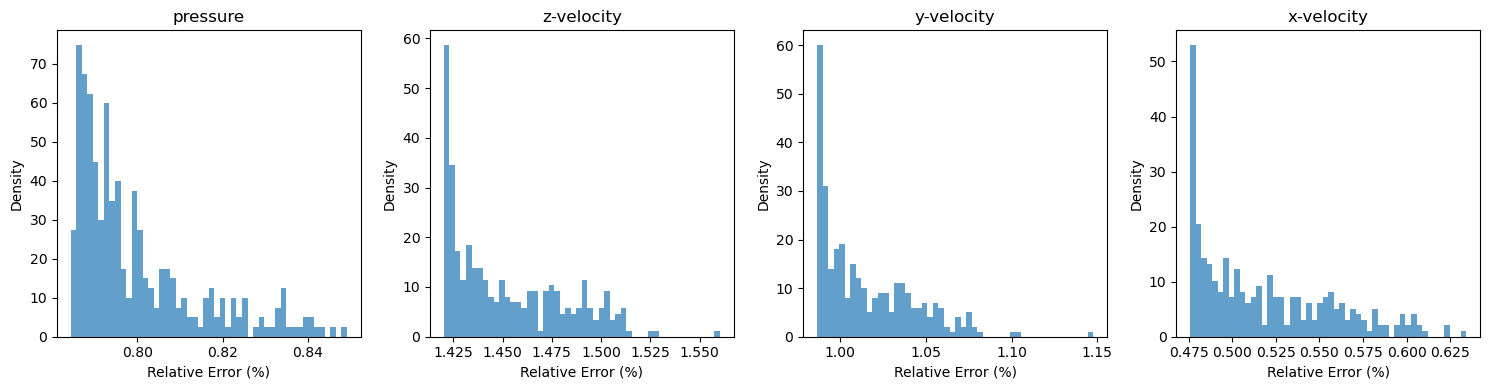

In [25]:
fig, ax = plt.subplots(1, target.shape[-1] - 1, figsize=(15, 4))

for i in range(target.shape[-1] - 1):
    ax[i].hist(rel_err[:, i] * 100, bins=50, density=True, alpha=0.7)
    ax[i].set_title(f'{target_label[i]}')
    ax[i].set_xlabel('Relative Error (%)')
    ax[i].set_ylabel('Density')
    
plt.tight_layout()
plt.show()

## Following Post-Processing

In [27]:
trunk_input.shape

(3977, 2)

In [35]:
import pandas as pd

def export_2d_csv(test_idx, predictions, targets, output_file):
    """
    Export predictions and targets to a CSV file.
    """
    df = pd.DataFrame()
    
    # node index
    df['node'] = np.arange(predictions.shape[1])
    
    # coordinate points
    df['y_coordinate'] = trunk_input_orig[:, 0]
    df['z_coordinate'] = trunk_input_orig[:, 1]
    
    pred_data = predictions[test_idx]
    target_data = targets[test_idx][..., :4]  # only the first 4 channels (p, w, v, u)
    
    print("Shape of pred_data:", pred_data.shape)
    print("Shape of target_data:", target_data.shape)
    
    # predictions
    df['pred_p'] = pred_data[:, 0]
    df['pred_w'] = pred_data[:, 1]
    df['pred_v'] = pred_data[:, 2]
    df['pred_u'] = pred_data[:, 3]
    # targets
    df['target_p'] = target_data[:, 0]
    df['target_w'] = target_data[:, 1]
    df['target_v'] = target_data[:, 2]
    df['target_u'] = target_data[:, 3]
    
    # Export to CSV
    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Data exported to {output_file}")
    else:
        print("No output file specified. Data not exported.")

In [36]:
export_2d_csv(highest_err_idx, predictions, targets, 'HeatExchanger/results/highest_error.csv')
export_2d_csv(lowest_err_idx, predictions, targets, 'HeatExchanger/results/lowest_error.csv')

Shape of pred_data: (3977, 4)
Shape of target_data: (3977, 4)
Data exported to HeatExchanger/results/highest_error.csv
Shape of pred_data: (3977, 4)
Shape of target_data: (3977, 4)
Data exported to HeatExchanger/results/lowest_error.csv
